### Install missing packages to kernel...


In [577]:
! pip install matplotlib
! pip install numpy
! pip install pandas
! pip install scikit-learn
! pip install scipy


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import packages...

In [602]:
# import pandas
import pandas as pd 
# Set maximimum display width to none... (so we can look at entire tweets)
pd.options.display.max_colwidth = None
# import numpy
import numpy as np
# import csr_matrix from scipy.parse
from scipy.sparse import csr_matrix
# import CountVectorizer from sklearn.feature_extraction.text
from sklearn.feature_extraction.text import CountVectorizer
# import normalize from sklearn.preprocessing
from sklearn.preprocessing import normalize
# import KMeans from sklearn.cluster
from sklearn.cluster import KMeans
# import AgglomerativeClustering from sklearn.cluster
from sklearn.cluster import AgglomerativeClustering
# import DBSCAN from sklearn.cluster
from sklearn.cluster import DBSCAN
# import SpectralClustering from sklearn.cluster
from sklearn.cluster import SpectralClustering
# import pdist and squareform from sklearn.cluster
from scipy.spatial.distance import pdist, squareform
# import cosine_similarity from sklearn.metrics.pairwise
from sklearn.metrics.pairwise import cosine_similarity
# import silhouette_score from sklearn.metrics
from sklearn.metrics import silhouette_score
# import matplotlib.pyplot
import matplotlib.pyplot as plt

# CSDS-435: Project #2
# Adam Brennan and Charlie Song

## Helper Functions...

In [603]:
def get_cnn_health_tweets_dataframe():
    # read in the cnnhealth.txt file using utf-8 encoding
    with open('cnnhealth.txt', 'r', encoding='utf-8') as cnn_health_tweets_dataset:
        # initialize empty list to store tweets
        tweets = []

        # for each row in the dataset, skip the first two columns and append the tweet to the tweets list
        for row in cnn_health_tweets_dataset:
            columns = row.strip().split('|')
            tweet = '|'.join(columns[2:])
            tweets.append([tweet])

    # convert list of tweets to pandas DataFrame
    df = pd.DataFrame(tweets, columns=['tweet'])
    
    # return the resulting pandas DataFrame
    return df

In [604]:
def get_bag_of_words_matrix(tweets_list, binary = False, output_to_file = False):
    # initialize CountVectorizer opbject 
    vectorizer = CountVectorizer(binary = binary)

    # build bag of words matrix from tweets list
    bag_of_words_matrix = vectorizer.fit_transform(tweets_list)

    # if output_to_file is set to true
    if(output_to_file):
        # output the bag of words matrix to a .txt file
        bag_of_words_matrix_csr = csr_matrix(bag_of_words_matrix)
        bag_of_words_matrix_array = bag_of_words_matrix_csr.toarray() 
        np.savetxt("bag_of_words_matrix.txt", bag_of_words_matrix_array, fmt="%d", delimiter=" ")
    
    # return the bag of words matrix
    return bag_of_words_matrix

In [605]:
def get_bag_of_words_dataframe(tweets_list):
    # initialize CountVectorizer opbject 
    vectorizer = CountVectorizer()

    # build bag of words matrix from tweets list
    bag_of_words_matrix = vectorizer.fit_transform(tweets_list)

    # convert bag of words matrix to a pandas DataFrame
    bag_of_words_df = pd.DataFrame(bag_of_words_matrix.toarray(), columns = vectorizer.get_feature_names_out())
    
    # return the bag of words dataframe
    return bag_of_words_df

In [606]:
def get_tweet(tweets_df, tweet_index):
    # return the tweet at the specified index in string form
    return str(tweets_df.iloc[tweet_index])

In [607]:
def get_tweets_summary_dataframe(tweets_list):
    # get the total number of tweets by getting the length of the tweets list
    num_tweets = len(tweets_list)
    # get the bag of words dataframe for the tweets list
    bag_of_words_dataframe = get_bag_of_words_dataframe(tweets_list)
    # get number of total tokens by counting nonzeros in the dataframe
    num_total_tokens = np.count_nonzero(bag_of_words_dataframe)
    # get number of unique tokens by getting column count of the dataframe
    num_unique_tokens = bag_of_words_dataframe.shape[1]
    # get average number of tokens per tweet by diving the total number of tokens by the number of tweets
    num_avg_tokens_per_tweet = num_total_tokens / num_tweets

    # create the DataFrame object
    row = [['CNN Health Tweets', num_tweets, num_total_tokens, num_unique_tokens, num_avg_tokens_per_tweet, 'A dataset containing tweets pertaining to health from CNN.']]
    columns = ['Dataset Name', '# Tweets', '# Total Tokens', '# Unique Tokens', 'Avg. Tokens Per Tweet', 'Description']
    tweets_summary_dataframe = pd.DataFrame(row, columns=columns)
    
    # return the created DataFrame
    return tweets_summary_dataframe

In [608]:
def get_cosine_similarity(bag_of_words_matrix):
    # get cosine similarities from bag of words matrix
    bag_of_words_matrix_cs = cosine_similarity(bag_of_words_matrix)

    # return cosine similarities
    return bag_of_words_matrix_cs

In [609]:
def get_cosine_distance(bag_of_words_matrix, output_to_file = False):
    # get the cosine distances from the bag of words matrix
    bag_of_words_matrix_cd = squareform(pdist(bag_of_words_matrix.toarray(), metric='cosine'))

    # if output_to_file is set to true, save the matrix to a .txt file
    if(output_to_file):
        np.savetxt("cosine_distance.txt", bag_of_words_matrix_cd, delimiter=',', fmt='%.2f')

    # return the cosine similarities
    return bag_of_words_matrix_cd

In [610]:
def get_jaccard_distance(tweets_list, output_to_file = False):
    # get binary bag of words matrix
    bag_of_words_matrix = get_bag_of_words_matrix(tweets_list, binary = True)

    # get the jaccard distances from the bag of words matrix
    bag_of_words_matrix_jd = squareform(pdist(bag_of_words_matrix.toarray(), metric="jaccard"))

    # if output_to_file is set to true, save the matrix to a .txt file
    if(output_to_file):
        np.savetxt("jaccard_distance.txt", bag_of_words_matrix_jd, delimiter=',', fmt='%.2f')
    
    return bag_of_words_matrix_jd

In [611]:
def estimate_number_of_clusters_using_elbow_method(start, end, bag_of_words_matrix):
    # declare empty list of SSEs
    sse = []
    # get normalized bag of words matrix
    normalized_bag_of_words_matrix = normalize(bag_of_words_matrix, norm = 'l2')
    for k in range(start, end):
        # run k means using num clusters of 'k'
        kmeans = KMeans(n_clusters=k, random_state=42)
        # fit data
        kmeans.fit(normalized_bag_of_words_matrix)
        # append inertia (sse)
        sse.append(kmeans.inertia_)

    # plot the elbow!
    plt.plot(range(start, end), sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.title('Elbow Method')
    plt.show()

In [612]:
def get_histogram_of_distance_measure(distance_measures_matrix, xlabel, ylabel, title):
    # get distance measures matrix
    distance_measures_matrix = distance_measures_matrix[np.triu_indices_from(distance_measures_matrix, k=1)]

    # plot the matrix!
    plt.hist(distance_measures_matrix, bins=10, edgecolor='black')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [613]:
def get_histogram_of_clusters(clusters_dataframe, title):
    # get the counts of each label (cluster)
    label_counts = clusters_dataframe.groupby('label').count()

    # plot the label counts!
    plt.figure(figsize=(8, 5))
    label_counts.plot(kind='bar', edgecolor='black')
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

In [614]:
def get_distance_matrix_heatmap(labels, distance_matrix):
    # sort the labels...
    si = np.argsort(labels)
    # sort distance matrix by the labels
    sdm = distance_matrix[si, :][:, si]

    # plot the heatmap!
    plt.figure(figsize=(8, 5))
    plt.imshow(sdm, interpolation='nearest')
    plt.colorbar(label='Distance')
    plt.title("Heatmap of Distance Matrix")
    plt.xlabel("Samples")
    plt.ylabel("Samples")
    plt.show()

In [615]:
def get_silhouette_score(bag_of_words_distance_matrix, labels):
    # calculate silhouette score from distance matrix...
    sc = silhouette_score(bag_of_words_distance_matrix, labels, metric='precomputed')

    return sc

## I. (10pts) parse it and construct feature vectors using bag-of-words, output result to a file, and generate summary statistics;

### Reading in the "cnnhealth.txt" file...

In [616]:
# get pandas DataFrame
tweets_df = get_cnn_health_tweets_dataframe()

# display DataFrame
tweets_df

,tweet
0,"An abundance of online info can turn us into e-hypochondriacs. Or, worse, lead us to neglect getting the care we need http://cnn.it/1L1t1Fv"
1,A plant-based diet that incorporates fish may be the key to preventing colorectal cancers: http://cnn.it/1xdpsjT http://pbs.twimg.com/media/CAARHEGWEAAJGz6.jpg
2,It doesn't take much to damage your hearing at a sports bar or nightclub. That's why a billion people are at risk. http://cnn.it/1BOphBk
3,RT @CNN: Forever young? Discover this island’s secrets to longevity on #TheWonderList w/ @BillWeirCNN http://cnn.it/1GNdmqc https://t.co/…
4,RT @CNN: Is post-traumatic stress disorder in your genes? A simple blood test may one day help tell you http://cnn.it/1xls8w5 http://t.co/…
...,...
4056,RT @EverydayHealth: Want killer abs? @JillianMichaels shows you how get them: http://at.cnn.com/ubAkAN
4057,Medicare at stake -- @sanjayguptaCNN talks about politicians' plans http://at.cnn.com/7nLSOm7
4058,Ann Romney talks about her experience with MS http://at.cnn.com/khb6keC
4059,Make sure your first marathon isn't your last! http://at.cnn.com/liehiPl


### Get tweet as list...

In [617]:
# get list of tweets
tweets_list = tweets_df['tweet'].tolist()

tweets_list

['An abundance of online info can turn us into e-hypochondriacs. Or, worse, lead us to neglect getting the care we need http://cnn.it/1L1t1Fv',
 'A plant-based diet that incorporates fish may be the key to preventing colorectal cancers: http://cnn.it/1xdpsjT http://pbs.twimg.com/media/CAARHEGWEAAJGz6.jpg',
 "It doesn't take much to damage your hearing at a sports bar or nightclub. That's why a billion people are at risk. http://cnn.it/1BOphBk",
 'RT @CNN: Forever young? Discover this island’s secrets to longevity on #TheWonderList w/ @BillWeirCNN  http://cnn.it/1GNdmqc https://t.co/…',
 'RT @CNN: Is post-traumatic stress disorder in your genes? A simple blood test may one day help tell you http://cnn.it/1xls8w5 http://t.co/…',
 'Maysoon Zayid, a touring standup comic with Cerebral Palsy, has a message to share. http://cnn.it/1GNiH0L http://pbs.twimg.com/media/B__ubV_UQAAUNOO.jpg',
 "How women can wipe out Alzheimer's, from @mariashriver.  http://cnn.it/1AklXJQ http://pbs.twimg.com/medi

In [618]:
bag_of_words_matrix = get_bag_of_words_matrix(tweets_list, output_to_file = True)

### Get the "bag of words" pandas DataFrame using the previously generated tweets pandas DataFrame...

In [619]:
# generate "bag of words" pandas DataFrame
bag_of_words_dataframe = get_bag_of_words_dataframe(tweets_list)

# display "bag of words" pandas DataFrame
bag_of_words_dataframe

,000,008relo,00fvvdw,00igyua,01,01tdt1o,02,03,04,05,...,zwwtu7,zxodiqo,zy53fec,zy7u11,zyam2xi,zyl,zyt5bpe,zzetat,zzgrrgf,zzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4056,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4057,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4058,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4059,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get the tweets summary DataFrame...

In [622]:
# generate "bag of words" pandas DataFrame
tweets_summary_dataframe = get_tweets_summary_dataframe(tweets_list)

# display resulting pandas DataFrame
tweets_summary_dataframe

,Dataset Name,# Tweets,# Total Tokens,# Unique Tokens,Avg. Tokens Per Tweet,Description
0,CNN Health Tweets,4061,69498,11264,17.113519,A dataset containing tweets pertaining to health from CNN.


## II. (10pts) construct  two distant measures, output results to two files, and generate histogram of the two distances;  

### Distance measure #1: Cosine Distance

In [ ]:
bag_of_words_matrix = get_bag_of_words_matrix(tweets_list)

bag_of_words_matrix_cs = get_cosine_distance(bag_of_words_matrix, output_to_file = True)

get_histogram_of_distance_measure(bag_of_words_matrix_cs, 'Cosine Distance', 'Frequency', 'Histogram of Cosine Distances')

### Distance measure #2: Jaccard Distance

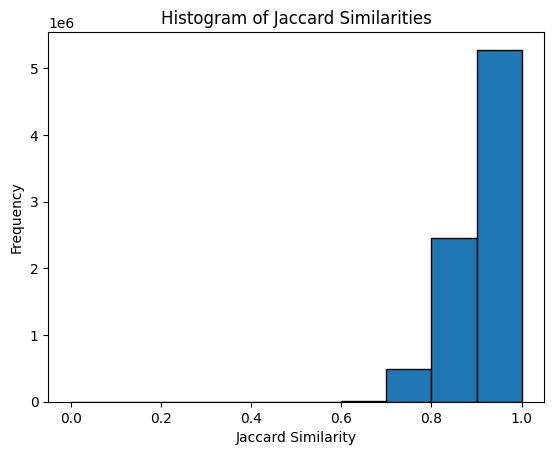

In [ ]:
bag_of_words_matrix_js = get_jaccard_distance(tweets_list, output_to_file = True)

get_histogram_of_distance_measure(bag_of_words_matrix_js, 'Jaccard Distance', 'Frequency', 'Histogram of Jaccard Distances')

## III. (20pts) implement 4 clustering algorithms (5pts for each method),

### Estimating the number of clusters using the elbow method...

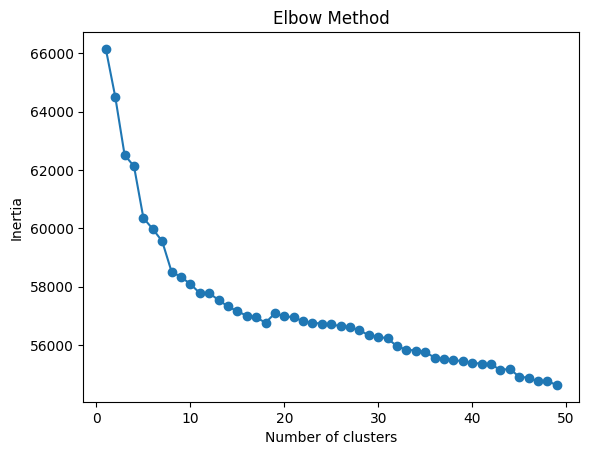

In [242]:
estimate_number_of_clusters_using_elbow_method(1, 50, bag_of_words_matrix)

In [471]:
n_clusters = 8

### Clustering using KMeans...

#### First cluster with cosine similarity as the distance measure...

In [478]:
bag_of_words_matrix_k_means = get_bag_of_words_matrix(tweets_list)
bag_of_words_matrix_k_means_normalized = normalize(bag_of_words_matrix_k_means, norm='l2')

km = KMeans(n_clusters = n_clusters, random_state = 42)
km.fit(bag_of_words_matrix_k_means_normalized)

k_means_labels = km.labels_
k_means_labels

array([6, 7, 4, ..., 1, 1, 1], dtype=int32)

#### Combine the labels and tweets in a DataFrame...

In [491]:
df = pd.DataFrame({
    'tweets': tweets_list,
    'label': k_means_labels
})

df

,tweets,label
0,"An abundance of online info can turn us into e-hypochondriacs. Or, worse, lead us to neglect getting the care we need http://cnn.it/1L1t1Fv",6
1,A plant-based diet that incorporates fish may be the key to preventing colorectal cancers: http://cnn.it/1xdpsjT http://pbs.twimg.com/media/CAARHEGWEAAJGz6.jpg,7
2,It doesn't take much to damage your hearing at a sports bar or nightclub. That's why a billion people are at risk. http://cnn.it/1BOphBk,4
3,RT @CNN: Forever young? Discover this island’s secrets to longevity on #TheWonderList w/ @BillWeirCNN http://cnn.it/1GNdmqc https://t.co/…,4
4,RT @CNN: Is post-traumatic stress disorder in your genes? A simple blood test may one day help tell you http://cnn.it/1xls8w5 http://t.co/…,4
...,...,...
4056,RT @EverydayHealth: Want killer abs? @JillianMichaels shows you how get them: http://at.cnn.com/ubAkAN,1
4057,Medicare at stake -- @sanjayguptaCNN talks about politicians' plans http://at.cnn.com/7nLSOm7,1
4058,Ann Romney talks about her experience with MS http://at.cnn.com/khb6keC,1
4059,Make sure your first marathon isn't your last! http://at.cnn.com/liehiPl,1


#### Show how many tweets are in each cluster...

In [480]:
df.groupby('label').count()

,tweets
label,
0,544
1,1244
2,212
3,423
4,637
5,395
6,320
7,286


#### Visualize the clusters with a barplot...

<Figure size 800x500 with 0 Axes>

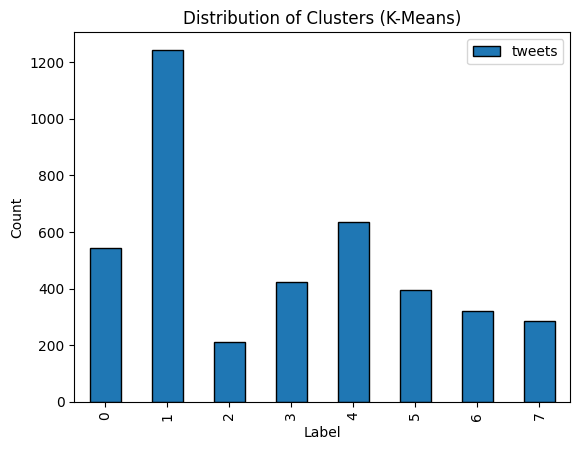

In [481]:
get_histogram_of_clusters(df, 'Distribution of Clusters (K-Means)')

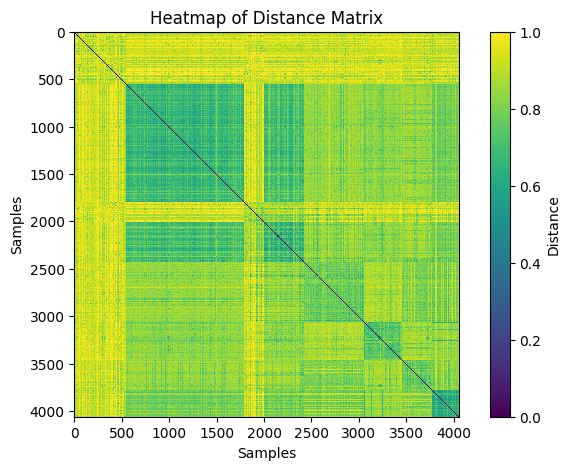

In [537]:
get_distance_matrix_heatmap(k_means_labels, bag_of_words_matrix_cs)

#### Calculate silhouette score...

In [482]:
silhouette_avg = silhouette_score(bag_of_words_matrix_k_means_normalized, k_means_labels, metric='cosine')

silhouette_avg

np.float64(0.04815529253982578)

### Clustering using Hierarhical Clustering...

#### First cluster with jaccard similarity as the distance measure...

In [495]:
ac = AgglomerativeClustering(n_clusters=n_clusters, metric="precomputed", linkage="average")
ac_labels = ac.fit_predict(bag_of_words_matrix_js)

#### Combine the labels and tweets in a DataFrame...

In [560]:
df = pd.DataFrame({
    'tweets': tweets_list,
    'label': ac_labels
})

df

,tweets,label
0,"An abundance of online info can turn us into e-hypochondriacs. Or, worse, lead us to neglect getting the care we need http://cnn.it/1L1t1Fv",1
1,A plant-based diet that incorporates fish may be the key to preventing colorectal cancers: http://cnn.it/1xdpsjT http://pbs.twimg.com/media/CAARHEGWEAAJGz6.jpg,1
2,It doesn't take much to damage your hearing at a sports bar or nightclub. That's why a billion people are at risk. http://cnn.it/1BOphBk,1
3,RT @CNN: Forever young? Discover this island’s secrets to longevity on #TheWonderList w/ @BillWeirCNN http://cnn.it/1GNdmqc https://t.co/…,1
4,RT @CNN: Is post-traumatic stress disorder in your genes? A simple blood test may one day help tell you http://cnn.it/1xls8w5 http://t.co/…,1
...,...,...
4056,RT @EverydayHealth: Want killer abs? @JillianMichaels shows you how get them: http://at.cnn.com/ubAkAN,1
4057,Medicare at stake -- @sanjayguptaCNN talks about politicians' plans http://at.cnn.com/7nLSOm7,1
4058,Ann Romney talks about her experience with MS http://at.cnn.com/khb6keC,1
4059,Make sure your first marathon isn't your last! http://at.cnn.com/liehiPl,1


#### Show how many tweets are in each cluster...

In [497]:
df.groupby('label').count()

,tweets
label,
0,37
1,3943
2,25
3,34
4,13
5,2
6,4
7,3


#### Visualize the clusters with a barplot...

<Figure size 800x500 with 0 Axes>

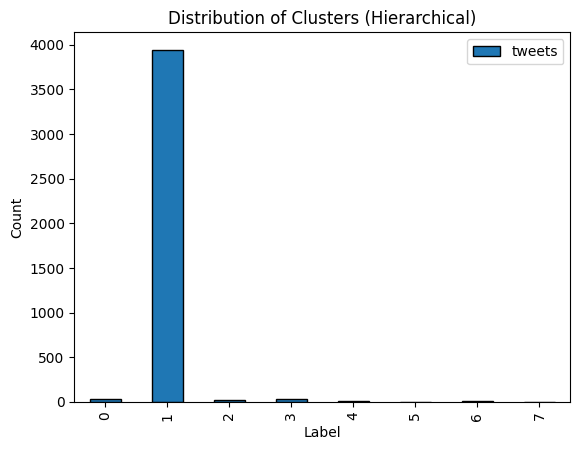

In [561]:
get_histogram_of_clusters(df, 'Distribution of Clusters (Hierarchical)')

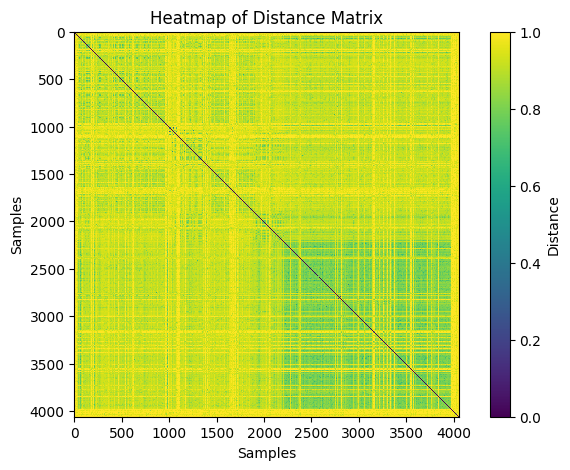

In [562]:
get_distance_matrix_heatmap(ac_labels, bag_of_words_matrix_js)

#### Calculate silhouette score...

In [563]:
ac_sc = get_silhouette_score(bag_of_words_matrix_js, ac_labels)

ac_sc

np.float64(0.06621477836526833)

### Clustering using DBSCAN...

#### First cluster with jaccard similarity as the distance measure...

In [564]:
dbs = DBSCAN(eps=0.9, min_samples=60, metric="precomputed")
dbs_labels = dbs.fit_predict(bag_of_words_matrix_js)

#### Combine the labels and tweets in a DataFrame...

In [565]:
df = pd.DataFrame({
    'tweets': tweets_list,
    'label': dbs_labels
})

df

,tweets,label
0,"An abundance of online info can turn us into e-hypochondriacs. Or, worse, lead us to neglect getting the care we need http://cnn.it/1L1t1Fv",0
1,A plant-based diet that incorporates fish may be the key to preventing colorectal cancers: http://cnn.it/1xdpsjT http://pbs.twimg.com/media/CAARHEGWEAAJGz6.jpg,0
2,It doesn't take much to damage your hearing at a sports bar or nightclub. That's why a billion people are at risk. http://cnn.it/1BOphBk,0
3,RT @CNN: Forever young? Discover this island’s secrets to longevity on #TheWonderList w/ @BillWeirCNN http://cnn.it/1GNdmqc https://t.co/…,0
4,RT @CNN: Is post-traumatic stress disorder in your genes? A simple blood test may one day help tell you http://cnn.it/1xls8w5 http://t.co/…,0
...,...,...
4056,RT @EverydayHealth: Want killer abs? @JillianMichaels shows you how get them: http://at.cnn.com/ubAkAN,0
4057,Medicare at stake -- @sanjayguptaCNN talks about politicians' plans http://at.cnn.com/7nLSOm7,0
4058,Ann Romney talks about her experience with MS http://at.cnn.com/khb6keC,0
4059,Make sure your first marathon isn't your last! http://at.cnn.com/liehiPl,0


#### Show how many tweets are in each cluster...

In [566]:
df.groupby('label').count()

,tweets
label,
-1,2
0,4059


#### Visualize the clusters with a barplot...

<Figure size 800x500 with 0 Axes>

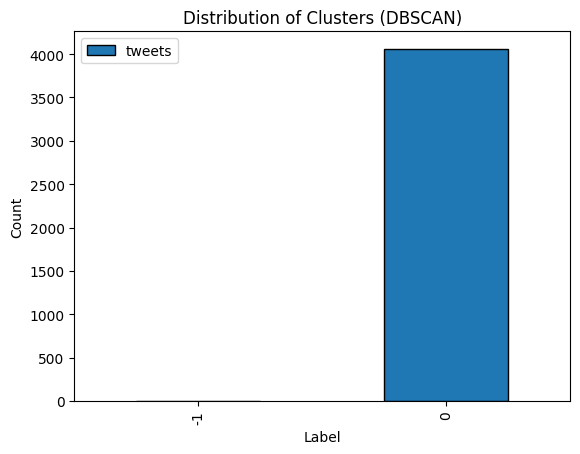

In [567]:
get_histogram_of_clusters(df, 'Distribution of Clusters (DBSCAN)')

#### Calculate silhouette score...

In [568]:
dbs_sc = get_silhouette_score(bag_of_words_matrix_js, dbs_labels)

dbs_sc

np.float64(0.08973540734405352)

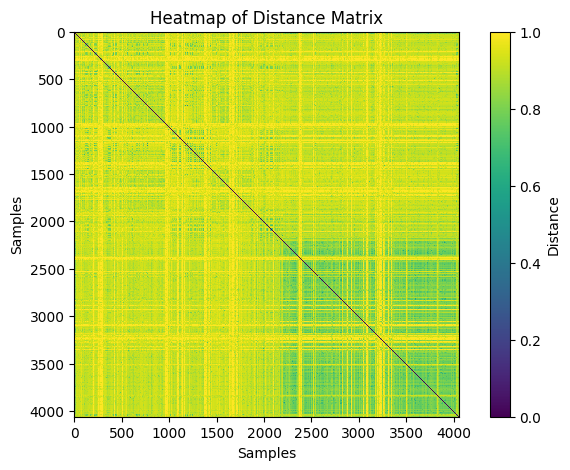

In [569]:
get_distance_matrix_heatmap(dbs_labels, bag_of_words_matrix_js)

### Clustering using Spectral Clustering...

In [571]:
sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)

sc_cs = get_cosine_similarity(bag_of_words_matrix)

sc_labels = sc.fit_predict(sc_cs)

#### Combine the labels and tweets in a DataFrame...

In [572]:
df = pd.DataFrame({
    'tweets': tweets_list,
    'label': sc_labels
})

df

,tweets,label
0,"An abundance of online info can turn us into e-hypochondriacs. Or, worse, lead us to neglect getting the care we need http://cnn.it/1L1t1Fv",7
1,A plant-based diet that incorporates fish may be the key to preventing colorectal cancers: http://cnn.it/1xdpsjT http://pbs.twimg.com/media/CAARHEGWEAAJGz6.jpg,7
2,It doesn't take much to damage your hearing at a sports bar or nightclub. That's why a billion people are at risk. http://cnn.it/1BOphBk,7
3,RT @CNN: Forever young? Discover this island’s secrets to longevity on #TheWonderList w/ @BillWeirCNN http://cnn.it/1GNdmqc https://t.co/…,7
4,RT @CNN: Is post-traumatic stress disorder in your genes? A simple blood test may one day help tell you http://cnn.it/1xls8w5 http://t.co/…,7
...,...,...
4056,RT @EverydayHealth: Want killer abs? @JillianMichaels shows you how get them: http://at.cnn.com/ubAkAN,0
4057,Medicare at stake -- @sanjayguptaCNN talks about politicians' plans http://at.cnn.com/7nLSOm7,0
4058,Ann Romney talks about her experience with MS http://at.cnn.com/khb6keC,0
4059,Make sure your first marathon isn't your last! http://at.cnn.com/liehiPl,0


#### Show how many tweets are in each cluster...

In [573]:
df.groupby('label').count()

,tweets
label,
0,1870
1,85
2,113
3,154
4,38
5,84
6,410
7,1307


#### Visualize the clusters with a barplot...

<Figure size 800x500 with 0 Axes>

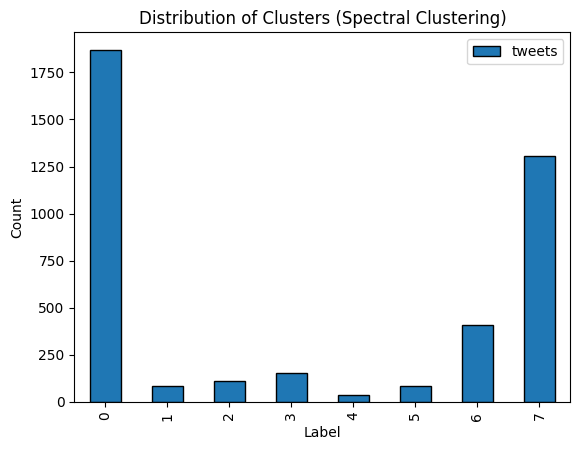

In [574]:
get_histogram_of_clusters(df, 'Distribution of Clusters (Spectral Clustering)')

#### Calculate silhouette score...

In [575]:
sc_ss = get_silhouette_score(bag_of_words_matrix_cs, sc_labels)

sc_ss

np.float64(0.092137881283308)

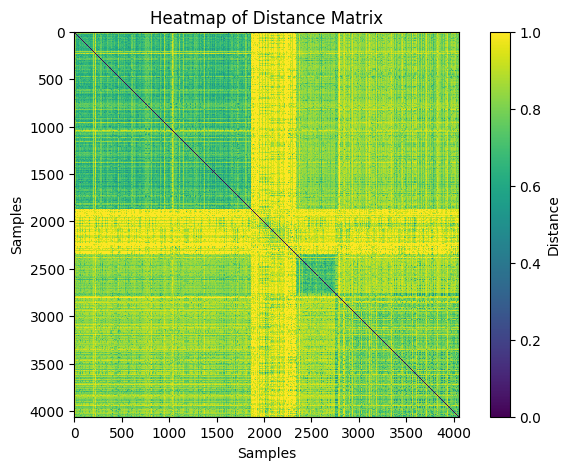

In [576]:
get_distance_matrix_heatmap(sc_labels, bag_of_words_matrix_cs)